In [1]:
import pandas as pd
import numpy as np
import scipy as scipy
import matplotlib.pyplot as plt
%matplotlib inline
from data.load_data import *
from sklearn.preprocessing import StandardScaler
import tensorflow_probability.substrates.jax.distributions as tfd
from dynamax.utils.utils import find_permutation
import seaborn as sns

#start coding the HMM for one session - load dynamax
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    if np.__version__ != '1.23.4':
        print('installing compatible numpy')
        %pip install -q numpy==1.23.4
    %pip install -q dynamax[notebooks]
    import dynamax
import warnings
warnings.filterwarnings("ignore")

# import jax
from functools import partial
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from dynamax.hidden_markov_model import GaussianHMM
from dynamax.hidden_markov_model import DiagonalGaussianHMM
from dynamax.hidden_markov_model import SphericalGaussianHMM
from dynamax.hidden_markov_model import SharedCovarianceGaussianHMM
from dynamax.utils.plotting import CMAP, COLORS, white_to_color_cmap

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
!pip install -q pyarrow

In [3]:
def minmax(x):
    # Function to normalize the data for easy visualization
    return (x - np.min(x))/(np.max(x) - np.min(x)) 


def AP_states(session_id,     best_num_states = 2):
    cache = load_cache_behavior_neuropixel()
    ecephys_sessions_table = cache.get_ecephys_session_table()
    
    #get the info for this session
    print('getting session info')
    session = cache.get_ecephys_session(session_id)
    # fun_key function to get the stimulus presentations we're interested in
    trial_df = get_trial_df(session)
    # extract behavioral variables for the trials we're interested in
    behavior = make_behavior_table_active(session,trial_df)
    #see what the behavior table looks like
    
    #get continuous behavioral varaibles for each stim presentation
    behavByStim = make_behavior_table_byStim(session,trial_df)
    #get trial-related behavioral variables for each trial
    behavior['Trials id']=behavior.index
    #combine both of the above, to get full data for each stim presentation
    fullData = pd.merge(behavByStim,behavior[['Trials id','Lick count','Rolling mean hit rate','Hit/miss this trial']],how='left',on='Trials id')
    fullData.loc[fullData.Active==False,['Lick count','Rolling mean hit rate','Hit/miss this trial']]=np.nan
    #convert to full data for each trial
    trialData=fullData.groupby(np.arange(len(fullData))//4).mean()
    # trialInds=trialData.index #will need these inds if doing HMM on full session
    
    #get smoothed versions of the continuous variables because they are noisy
    trialData['Smoothed speed']=trialData['Mean speed'].rolling(5).mean()
    trialData['Smoothed pupil']=trialData['Mean pupil area'].rolling(5).mean()
    
    
    #active and passive
    trialInds=trialData.index

    #split off a subset for active only
    trialDataActive=trialData[trialData['Active']==True]
    trialIndsA=trialDataActive.index #will need these inds if doing HMM on active only

    #split off a subset for passive only
    trialDataPassive=trialData[trialData['Active']==False]
    trialIndsP=trialDataPassive.index

    # organizing data for HMM
    data = trialData[['Smoothed speed', 'Smoothed pupil']].values
    nInputs = len(data)
    
    scaler = StandardScaler()  
    
    # replace the first four rows of the smoothed data with the non-smoothed data to avoid NANs
    #trialDataActive[['Lick count','Smoothed speed', 'Smoothed pupil']].values

    smothSpeedArray = trialData['Smoothed speed'].values
    smothPupilArray = trialData['Smoothed pupil'].values
    #lickCountArray=trialDataActive['Lick count'].values
    smothSpeedArray[0:4]=trialData['Mean speed'].values[0:4]
    smothPupilArray[0:4]=trialData['Mean pupil area'].values[0:4]
    #lickCountArray[0:4]=0
    input_data = np.vstack([smothSpeedArray,smothPupilArray]).T

    input_data = scaler.fit_transform(input_data)
    print(input_data.shape)
    # input_data  = trialDataActive[['Lick count','Smoothed speed', 'Smoothed pupil']].values
    
    #re-run the model haivg selected your number of states
    print('running HMM...')


    key = jr.PRNGKey(0)

    number_of_states = best_num_states

    final_hmm = GaussianHMM(best_num_states, input_data.shape[1], transition_matrix_stickiness=10.)

    params, props = final_hmm.initialize(key=key, method="kmeans", emissions=input_data)

    params, lps = final_hmm.fit_em(params, props, input_data, num_iters=500)
    
    #plotting the learned transition matrix
    fig, ax = plt.subplots(1, 2, figsize =(6, 3))
    sns.heatmap(np.squeeze(params.transitions), annot=True, ax = ax[0])
    
    ax[1].plot(params.emissions.means)#similar emission means will be comparable states across mice.
    ax[1].legend(['running', 'pupil'])
    plt.suptitle(session_id)
    plt.tight_layout()
    
    states_new = []
    states = final_hmm.most_likely_states(params, input_data)

    emission_means = params.emissions.means

    states_new = [1 if emission_means[state_no, 0] <= emission_means[state_no, 1] else 0 for state_no in states]

    states_new = [1 if emission_means[state_no, 0] <= emission_means[state_no, 1] else 0 for state_no in states]
    states_color = ['#FF7518' if x==1 else '#2AAA8A' for x in states_new]
    
    # scatter plot
    fig, ax = plt.subplots(figsize = (3, 3))
    plt.scatter(input_data[:, 0], input_data[:, 1], marker = 'o', c = states_color)
    plt.xlabel('running')
    plt.ylabel('pupil')
    plt.tight_layout()

    # Overlay the precision and recall curves on top of the inferred states
    fig, ax = plt.subplots(figsize=(12, 4))
    cmap =sns.color_palette("Set2", best_num_states)
    bounds=np.arange(-0.5, best_num_states, 0.5)

    # Define state boundaries 
    states = states_new
    switch_trials = np.where(np.diff(states))[0]
    switch_trials = np.concatenate(([0], switch_trials, [len(trialInds)-1]))

    # Plot the states 
    for i, trial in enumerate(switch_trials[:-1]):
        for state_no in range(best_num_states):
            if states[trial+1] == state_no: 
                ax.axvspan(trialInds[trial], trialInds[switch_trials[i+1]], 
                           facecolor= cmap[state_no], alpha=0.9, label = 'State' + str(state_no))

    
    # Overlay behavioral variables 
    plt.plot(trialInds, minmax(trialData['Smoothed speed']), color = 'black', label="Running Speed", lw = 1)
    plt.plot(trialInds, minmax(trialData['Smoothed pupil']), color = 'tab:blue', label="Pupil Area", lw = 1)
    #plt.plot(trialInds, minmax(trialData['Rolling mean hit rate']), color = 'blue', label="Hit rate", lw = 1)
    
    # Formatting 
    plt.xlim(trialInds[0], trialInds[-1])
    plt.ylabel("normalized activity")
    plt.xlabel("trials")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor = (1.01, 1), fontsize = 8)
    plt.tight_layout()
    
    trialData['state']=np.nan
    trialData['state']=states_new
    
    trialDataby4 = pd.DataFrame(np.repeat(trialData.to_numpy(), 4, axis=0), columns=trialData.columns)
    trialDataby4.reset_index(inplace = True)
    
    trial_df.reset_index(inplace = True)
    
    trial_df1 = pd.merge(trial_df, trialDataby4[['Lick count', 'Rolling mean hit rate', 'Hit/miss this trial', 'Smoothed speed', 'Smoothed pupil', 'state']],on = trialDataby4.index.values, how= 'outer')

    
    trial_df1.to_feather('../analysis_data/AP' + str(session_id) + '_new.feather')   

    plt.show()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
1053925378
getting session info
(462, 2)
running HMM...


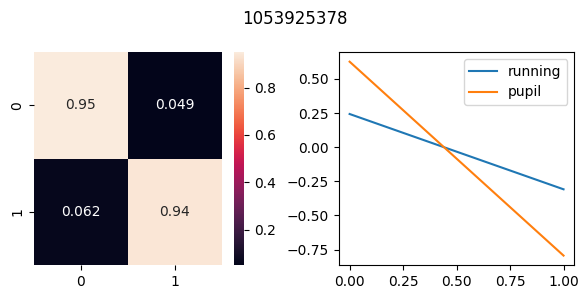

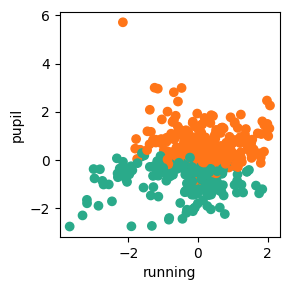

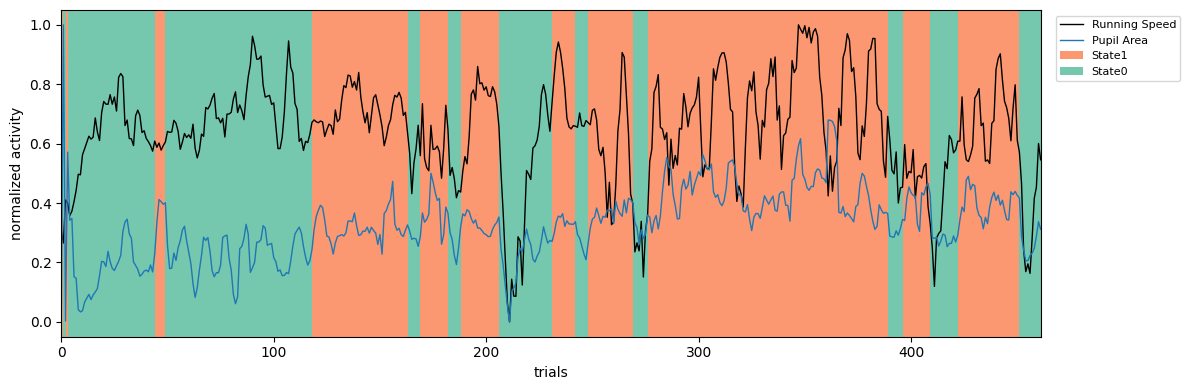

1081090969
getting session info
(430, 2)
running HMM...


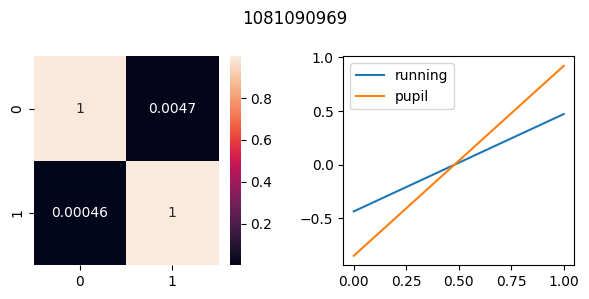

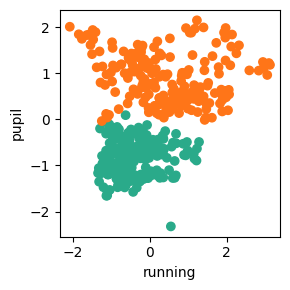

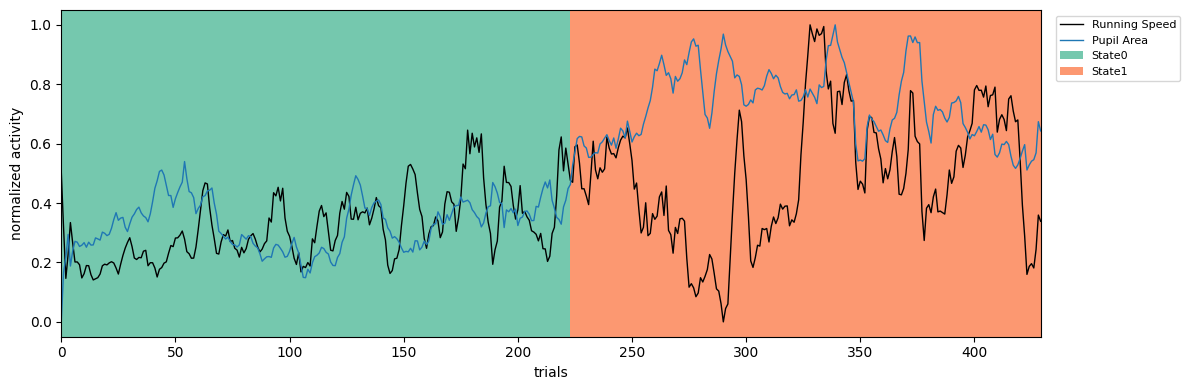

1064415305
getting session info
(482, 2)
running HMM...


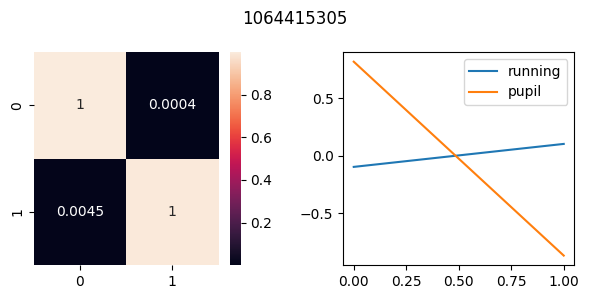

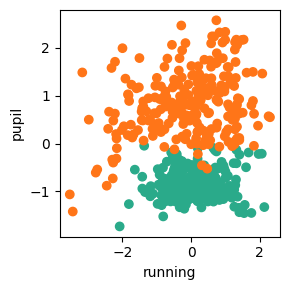

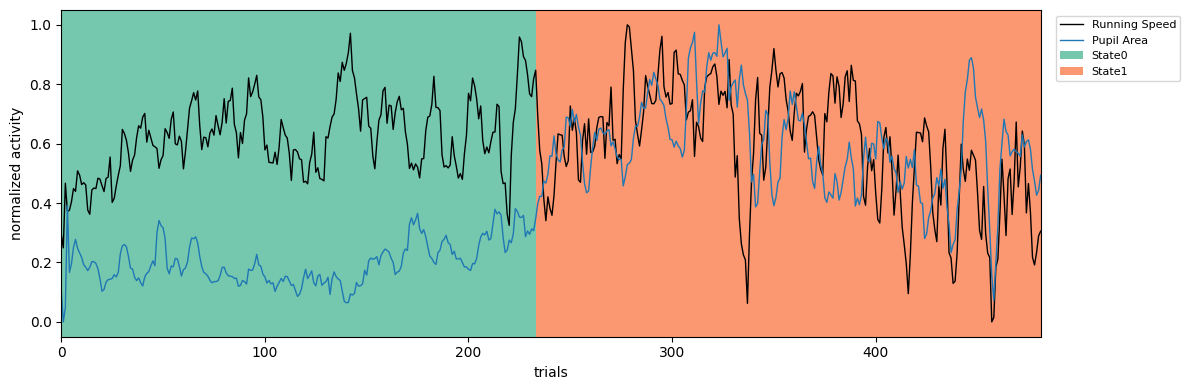

1108334384
getting session info
(518, 2)
running HMM...


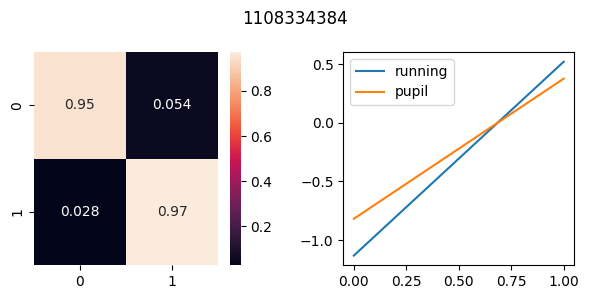

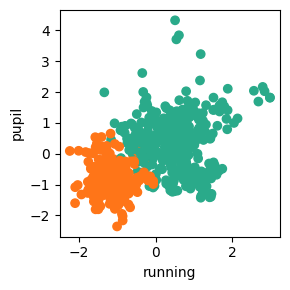

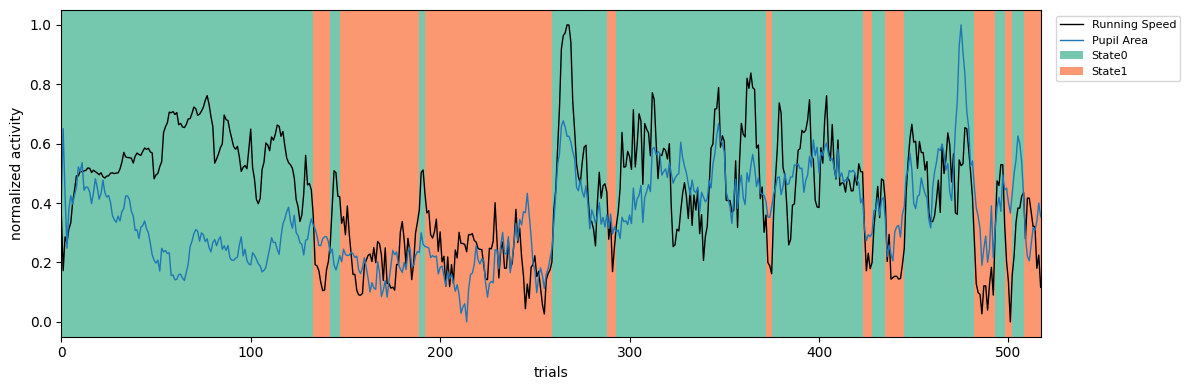

1115356973
getting session info
(556, 2)
running HMM...


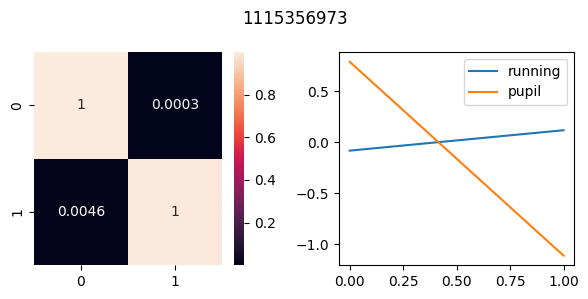

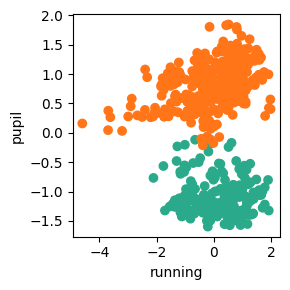

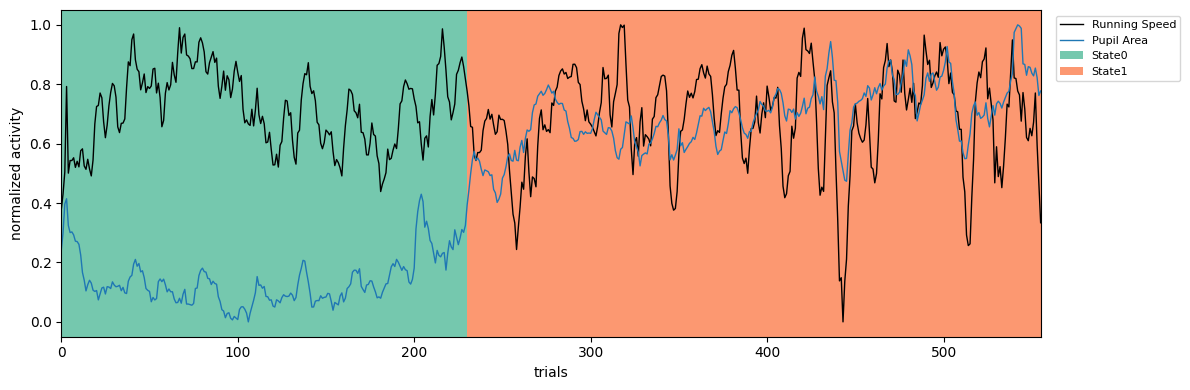

In [4]:
%time
example_sessions = [1053925378, 1081090969, 1064415305, 1108334384, 1115356973]
for session_id in example_sessions:
    print(session_id)
    AP_states(session_id)